In [1]:
%run imports.ipynb

In [2]:
li2016_calls = pd.read_excel('source_data/variant_calls.xlsx', sheet_name='Li2016')
li2016_calls.rename({'Name': 'name'}, axis=1).to_csv('source_data/li2016_variant_calls.csv', index=False)

li2016_calls = pd.read_csv('source_data/li2016_variant_calls.csv')
sample2status = {r.name:r.status for r in li2016_calls.to_records()}

run2status = {r.run_rrbs:r.status for r in li2016_calls.to_records()}

In [12]:
context2bed = {
    'cgi': 'beds/hg38.cgi.sorted.bed',
    'cpg_shore': 'beds/hg38.cgi_shores.pure.sorted.bed',
    'cpg_shelf': 'beds/hg38.cgi_shelves.pure.sorted.bed',
    'promoter': 'beds/gencode.v32.promoter.sorted.bed',
    'methylation_canyon': 'beds/methylation_canyons_hg38.sorted.bed',
    'exon': 'beds/gencode.v32.exon.pure.sorted.bed',
    'genebody': 'beds/gencode.v32.genebody.pure.sorted.bed',
    'sine': 'beds/sine.sorted.bed',
    'line': 'beds/line.sorted.bed',
    'ltr': 'beds/ltr.sorted.bed',
    'bivalent_domain': '/data/project/SNUH_DNMT3A/note2/results/CHROMATIN-STATES/bivalent_domains.sorted.bed',
    'bivalent_promoter': 'beds/gencode.v32.bivalent_promoter.sorted.bed',
    'nonbivalent_promoter': 'beds/gencode.v32.nonbivalent_promoter.sorted.bed',
    'bivalent_promoter_bivslop1000': 'beds/gencode.v32.bivalent_promoter.bivslop1000.sorted.bed',
    'nonbivalent_promoter_bivslop1000': 'beds/gencode.v32.nonbivalent_promoter.bivslop1000.sorted.bed',
    # 'panel': '/data/project/SNUH_DNMT3A/note2/results/BS-PANEL-SELECTION/panel.sorted.bed',
}

contexts = [
    'cgi', 'cpg_shore', 'cpg_shelf', 'promoter',
    'methylation_canyon', 'exon', 'genebody', 'sine', 'line', 'ltr',
    'bivalent_domain', 'bivalent_promoter', 'nonbivalent_promoter', 'bivalent_promoter_bivslop1000', 'nonbivalent_promoter_bivslop1000',
    'all', 'intergenic',
]

In [13]:
result_dir = '/data3/project/SNUH_DNMT3A/pipelines/METHEOR/result_pm/DBGAP-ERRBS/'

data = defaultdict(list)
for run, status in tqdm(run2status.items()):
    for context in contexts:
        tmp = pd.read_csv(result_dir + f'{run}.{context}.pm.tsv', sep='\t', names=['chrom', 'cpg1', 'cpg2', 'cpg3', 'cpg4', 'pm'])

        data['run'].append(run)
        data['context'].append(context)
        data['status'].append(status)
        data['pm'].append(tmp.pm.mean())
        
data = pd.DataFrame(data)

100%|██████████| 108/108 [12:28<00:00,  6.93s/it]


In [15]:
data.to_csv('source_data/li2016_context_specific_pm.csv', index=False)

In [19]:
context2cpgcount = {
    'all': 1371701,
    'intergenic': 85712,
    'promoter': 665169,
    'cgi': 704068,
    'cpg_shore': 175413,
    'cpg_shelf': 95173,
    'sine': 189338,
    'line': 20257,
    'ltr': 38142,
    'genebody': 405623,
    'exon': 114353,
    'methylation_canyon': 206354,
    'bivalent_domain': 223428,
}

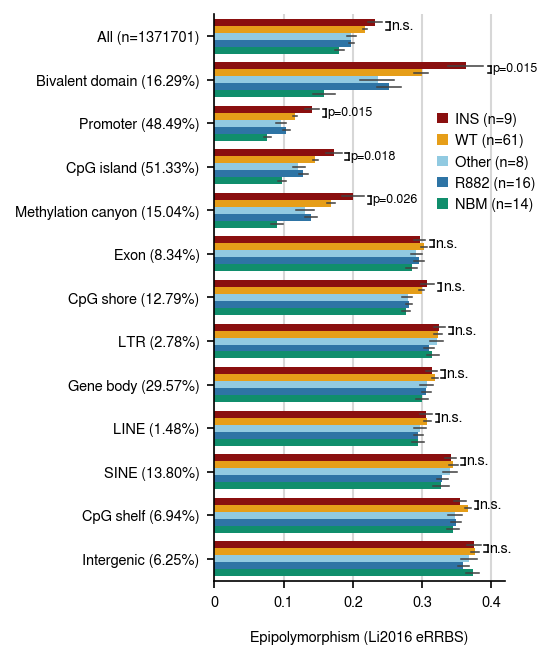

In [40]:
from scipy.stats import ttest_ind, mannwhitneyu
from matplotlib.ticker import FormatStrFormatter

format_context = {
    'all': 'All',
    'promoter': 'Promoter',
    'cgi': 'CpG island',
    'methylation_canyon': 'Methylation canyon',
    'exon': 'Exon',
    'genebody': 'Gene body',
    'sine': 'SINE',
    'intergenic': 'Intergenic',
    'cpg_shelf': 'CpG shelf',
    'ltr': 'LTR',
    'line': 'LINE',
    'cpg_shore': 'CpG shore',
    'bivalent_domain': 'Bivalent domain',
    'bivalent_promoter': 'Bivalent promoter',
    'nonbivalent_promoter': 'Non-bivalent promoter',
}

plt.rc('lines', linewidth=0.75)

# order = ['all', 'bivalent_domain'] + data[~data.context.isin(['all', 'bivalent_domain', 'nonbivalent_promoter', 'bivalent_promoter', 'nonbivalent_promoter_bivslop1000', 'bivalent_promoter_bivslop1000'])].groupby('context').agg({'lpmd': 'mean'}).reset_index().sort_values('lpmd').context.tolist()
order = [
    'all',
    'bivalent_domain',
    'promoter',
    'cgi',
    'methylation_canyon',
    'exon',
    'cpg_shore',
    'ltr',
    'genebody',
    'line',
    'sine',
    'cpg_shelf',
    'intergenic',
]
hue_order = ['INS', 'WT', 'Other', 'R882', 'NBM']
palette = ['#990000', 'orange', 'skyblue', 'C0', '#009e73']

fig = plt.figure(figsize=(2.5, 5))
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
ax.grid(axis='x', lw=1, alpha=0.5)

sns.barplot(
    data=data,
    y='context',
    x='pm',
    hue='status',
    hue_order=hue_order,
    order=order,
    palette=palette,
    orient='h',
    ci=68,
    errwidth=0.75,
    saturation=0.8,
)

for i, context in enumerate(order):
    a = data[(data.context == context) & (data.status == 'WT')].pm
    b = data[(data.context == context) & (data.status == 'INS')].pm
    p = mannwhitneyu(a, b).pvalue
    
    max_x = 0
    for status in ['INS', 'WT', 'Other', 'R882', 'NBM']:
        d = data[(data.context == context) & (data.status == status)]
        max_x = np.max([max_x, d.pm.mean() + d.pm.std() / np.sqrt(len(d))])
                            
    ax.plot([max_x + 0.01, max_x + 0.01], [i - 0.325, i - 0.15], c='k', lw=0.75)
    ax.plot([max_x + 0.005, max_x + 0.01], [i - 0.325, i - 0.325], c='k', lw=0.75)
    ax.plot([max_x + 0.005, max_x + 0.01], [i - 0.15, i - 0.15], c='k', lw=0.75)
    
    if p < 0.05:
        ax.text(max_x + 0.012, i - 0.25, f'p={p:.2g}', va='center', ha='left', fontsize=6)
    else:
        ax.text(max_x + 0.012, i - 0.25, f'n.s.', va='center', ha='left', fontsize=7)
    
for d in ['top', 'right']:
    ax.spines[d].set_visible(False)

ax.set_xlabel('Epipolymorphism (Li2016 eRRBS)', fontsize=7, labelpad=10)
ax.set_ylabel('')
ax.set_ylim([-0.5, len(order) - 0.5])
ax.invert_yaxis()


tmp = data[(data.context == context)]
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels[:5]:
    new_labels.append(label + ' (n=%d)' % (np.sum(tmp['status'] == label)))
handles = handles[:5]
ax.legend(handles, new_labels, frameon=False, fontsize=7, loc='upper right', handlelength=0.7, handletextpad=0.5, bbox_to_anchor=(1.15, 0.85))

# xticklabels = [t.get_text() for t in ax.get_xticklabels()]
# xticklabels[0] = '0'
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
# print(x)
# ax.set_xticklabels(xticklabels)
# ax.set_xticklabels([0] + list([t.get_position()[0] for t in xticklabels[1:]]))
ax.set_yticklabels([f'{format_context[c]} (n={context2cpgcount["all"]})' if c == 'all' else f'{format_context[c]} ({context2cpgcount[c] / context2cpgcount["all"]:.2%})' for c in order])

save_figures('source_data_figures/pm_context_analysis/pm_context_full')